<a href="https://colab.research.google.com/github/Pheobe-Sun/audio-and-speech-demo/blob/master/Clustering_onsets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Means Clustering

This notebook is adapted from [this](https://musicinformationretrieval.com/kmeans.html) MIR note

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import librosa
from librosa import display
import os
import glob
from IPython.display import Audio

## Data Loading

In [2]:
#@markdown Load some sample audio
# !wget https://github.com/Pheobe-Sun/audio-and-speech-demo/blob/master/audio/voice_three.wav
!wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/170255__dublie__trumpet.wav

# import urllib.request
# urllib.request.urlopen('http://audio.musicinformationretrieval.com/c_strum.wav', 'c_strum.wav')
# urllib.request.urlopen('https://github.com/Pheobe-Sun/audio-and-speech-demo/blob/master/audio/voice_three.wav', 'voice_three.wav')

--2021-09-09 09:34:51--  https://github.com/AllenDowney/ThinkDSP/raw/master/code/170255__dublie__trumpet.wav
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/170255__dublie__trumpet.wav [following]
--2021-09-09 09:34:52--  https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/170255__dublie__trumpet.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1540668 (1.5M) [audio/wav]
Saving to: ‘170255__dublie__trumpet.wav’

170255__dublie__tru 100%[===================>]   1.47M  --.-KB/s    in 0.07s   

2021-09-09 09:34:52 (21.3 MB/s) - ‘170255__dublie__tru

In [3]:
y, sr = librosa.load('170255__dublie__trumpet.wav')

print(f'Data dimension: {y.shape}')
print(f'Sampling rate is: {sr}')
print(f'Audio duration: {librosa.get_duration(y, sr):.3}s')

Audio(data=y, rate=sr) # Play back the loaded audio file

Data dimension: (192562,)
Sampling rate is: 22050
Audio duration: 8.73s


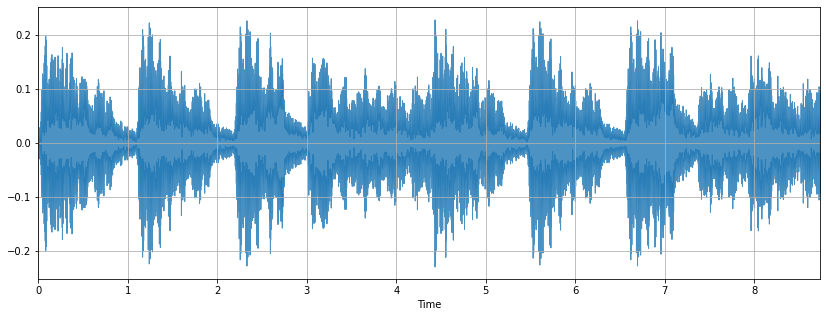

In [7]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr, alpha=0.8)
plt.grid()

## Feature Extraction

### Onset Detection

In [19]:
onset_frames = librosa.onset.onset_detect(y, sr=sr, delta=0.04, wait=4)

onset_times = librosa.frames_to_time(onset_frames, sr=sr)
onset_samples = librosa.frames_to_samples(onset_frames)

print(f'Onset frames dimension: {onset_frames.shape}')
print(f'Onset frames: {onset_frames}')

print(f'\nAudio duration: {librosa.get_duration(y, sr):.3}s')
print(f'Onset times: {np.around(onset_times, 2)}')

print(f'\nSampling rate is: {sr}')
print(f'Total samples: {y.shape[0]}')
print(f'Onset samples: {onset_samples}')

Onset frames dimension: (36,)
Onset frames: [  3  18  30  44  49  60  65  76  96 109 117 126 131 142 149 155 170 184
 191 205 217 223 232 237 248 253 264 284 297 302 319 331 343 349 357 371]

Audio duration: 8.73s
Onset times: [0.07 0.42 0.7  1.02 1.14 1.39 1.51 1.76 2.23 2.53 2.72 2.93 3.04 3.3
 3.46 3.6  3.95 4.27 4.44 4.76 5.04 5.18 5.39 5.5  5.76 5.87 6.13 6.59
 6.9  7.01 7.41 7.69 7.96 8.1  8.29 8.61]

Sampling rate is: 22050
Total samples: 192562
Onset samples: [  1536   9216  15360  22528  25088  30720  33280  38912  49152  55808
  59904  64512  67072  72704  76288  79360  87040  94208  97792 104960
 111104 114176 118784 121344 126976 129536 135168 145408 152064 154624
 163328 169472 175616 178688 182784 189952]


### Zero crossings & energy extraction

In [57]:
def extract_features(x, sr):
    zcr = librosa.zero_crossings(x).sum() # zero crossings 
    energy = np.linalg.norm(x) # energy
    return [zcr, energy]

In [58]:
frame_sz = round(sr * 0.084) # window size, aka samples per frame
features = np.array([extract_features(y[i: i+frame_sz], sr) for i in onset_samples])
print(features[:5])

[[156.           2.10766006]
 [243.           1.60592341]
 [145.           1.1613704 ]
 [143.           0.38594463]
 [152.           2.20670795]]


### Feature scaling

In [61]:
from scipy import stats
print(stats.describe(features[:,0]))
print(stats.describe(features[:,1]))

DescribeResult(nobs=36, minmax=(108.0, 273.0), mean=176.86111111111111, variance=1866.7515873015873, skewness=0.6372386969356414, kurtosis=-0.6009068513254303)
DescribeResult(nobs=36, minmax=(0.38186413049697876, 2.4462757110595703), mean=1.5635193445616298, variance=0.2850245719540241, skewness=-0.4105500713813245, kurtosis=-0.2540564583688143)


In [70]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
print(scaled_features.shape)
print(scaled_features.min(axis=0))
print(scaled_features.max(axis=0))
print(scaled_features.std(axis=0))

(36, 2)
[0. 0.]
[1. 1.]
[0.25819159 0.25499263]


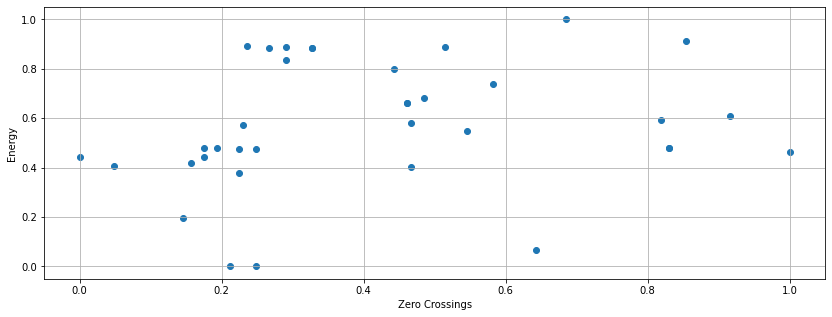

In [75]:
plt.figure(figsize=(14, 5))
plt.scatter(scaled_features[:,0], scaled_features[:,1])
plt.xlabel('Zero Crossings')
plt.ylabel('Energy')
plt.grid()
plt.show()

## K-Means

In [79]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(scaled_features)
labels = kmeans.labels_
print(labels)
print(kmeans.cluster_centers_)

[0 0 1 1 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 1 1 0 0 0 1 0 0 0 0 1 0 0 1 1]
[[0.55382395 0.73187427]
 [0.22626263 0.34911978]]


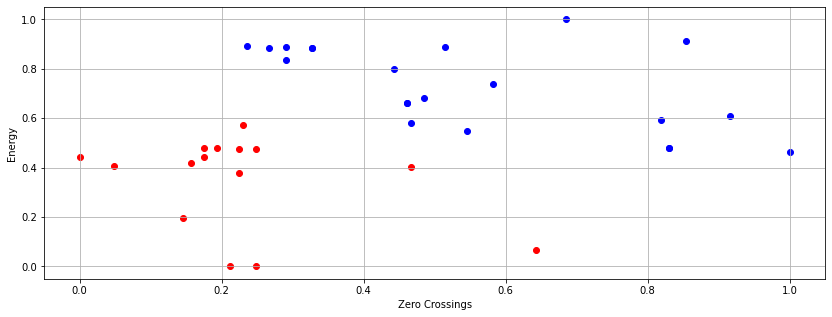

In [82]:
plt.figure(figsize=(14, 5))
plt.scatter(scaled_features[labels==0, 0], scaled_features[labels==0, 1], c='b')
plt.scatter(scaled_features[labels==1, 0], scaled_features[labels==1, 1], c='r')
plt.xlabel('Zero Crossings')
plt.ylabel('Energy')
plt.grid()
plt.show()

Sonify the classified onsets using ``mir_eval`` ([documentation](https://craffel.github.io/mir_eval/))

In [89]:
#@markdown Install mir_eval
!pip install mir_eval
import mir_eval.display

In [87]:
# Class 0
x_with_beeps = mir_eval.sonify.clicks(onset_times[labels==0], sr, length=len(y))
Audio(y + x_with_beeps, rate=sr)

In [88]:
# Class 1
x_with_beeps = mir_eval.sonify.clicks(onset_times[labels==1], sr, length=len(y))
Audio(y + x_with_beeps, rate=sr)

## Affinity Propagation